# STK player bot detector with SageMaker Linear Regression - Logistic Regression¶


#### Install packages

In [1]:
%%bash 
home=`pwd`
. $home/env
pip3 install mysql-connector-python

bash: line 2: /home/ec2-user/SageMaker/amazon-aurora-call-to-amazon-sagemaker-sample/stk-sample/env-build/sagemaker/env: No such file or directory
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import sagemaker
execution_role = sagemaker.get_execution_role()
print(execution_role)

arn:aws:iam::163538056407:role/service-role/AmazonSageMaker-ExecutionRole-20200913T212219


### Get training and test data from Aurora DB

In [3]:
%%time

import json
import boto3
import csv
import mysql.connector
import sys
import os
import configparser

config = configparser.ConfigParser()

config.read('rds.ini')

ENDPOINT=config['default']['ENDPOINT']
USR=config['default']['USR']
PASWD=config['default']['PASWD']
REGION=config['default']['REGION']
DBNAME=config['default']['DBNAME']

client = boto3.client('rds')

CPU times: user 72.7 ms, sys: 156 µs, total: 72.8 ms
Wall time: 1.12 s


Getting the right size of the grouping

In [53]:
%%time
import pandas as pd

group_size=100

try:
  conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
  cur = conn.cursor()
  cur.execute("""SELECT count(id) from actions where class is not null""")
  actions_size_list=cur.fetchall()
  actions_size_df=pd.DataFrame(actions_size_list)
  actions_size=actions_size_df[0].values[0]
  print("actions_size="+str(actions_size))
  modulo_size=actions_size/group_size
  print("modulo_size="+str(modulo_size))
except Exception as e:
  print("Database connection failed due to {}".format(e))

actions_size=72445
modulo_size=724.45
CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 86.2 ms


In [229]:
%%time
import pandas as pd

modulo_size=100

try:
  conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
  cur = conn.cursor()
  
  cur.execute("""SELECT id,m_ticks,m_action,m_value,m_value_l,m_value_r,class FROM actions WHERE class=1 order by id""")
  bot_action_list=cur.fetchall()
  cur.execute("""SELECT id,m_ticks,m_action,m_value,m_value_l,m_value_r,class FROM actions WHERE class=0 order by id""")
  player_action_list=cur.fetchall()  
  cur.execute("""
                  SELECT FLOOR(id/100) sessionid,id,m_ticks,m_kart_id,m_action,m_value,m_value_l,m_value_r,class
                  FROM actions 
                  WHERE class IS NOT NULL
                  ORDER BY id,m_kart_id 
              """)
  action_list=cur.fetchall()  
except Exception as e:
  print("Database connection failed due to {}".format(e))
  

CPU times: user 243 ms, sys: 36.8 ms, total: 280 ms
Wall time: 404 ms


### Investigate and process the data

In [81]:
import pandas as pd
bot_actions = pd.DataFrame(bot_action_list)
player_actions = pd.DataFrame(player_action_list)

In [82]:
bot_actions.rename(columns={0:'id',
                            1:'m_ticks',
                            2:'m_action',
                            3:'m_value',
                            4:'m_value_l',
                            5:'m_value_r',
                            6:'class'
                           }, 
                 inplace=True)

In [83]:
player_actions.rename(columns={0:'id',
                            1:'m_ticks',
                            2:'m_action',
                            3:'m_value',
                            4:'m_value_l',
                            5:'m_value_r',
                            6:'class'
                           }, 
                 inplace=True)

### Let's look for interesting data patterns

In [84]:
import matplotlib.pyplot as plt
import pandas as pd

#### Corralation between ticks in bots and humans

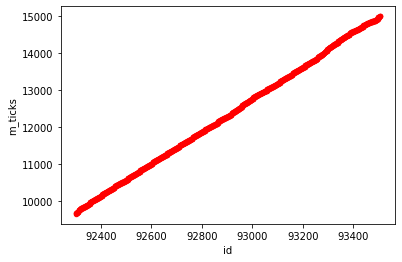

In [85]:
bot_actions[600:1800].plot(kind='scatter',x='id',y='m_ticks',color='red')
plt.show()

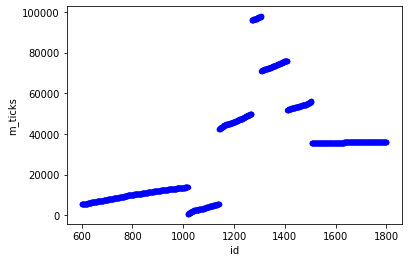

In [86]:
player_actions[600:1800].plot(kind='scatter',x='id',y='m_ticks',color='blue')
plt.show()

Correlation between action values in bots and humans

We can see that `m_ticks` are random for humans and consistent for bots.


#### Correlation between action values in bots and humans

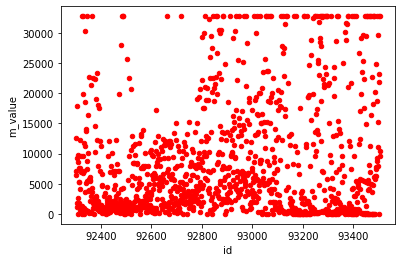

In [87]:
bot_actions[600:1800].plot(kind='scatter',x='id',y='m_value',color='red')
plt.show()

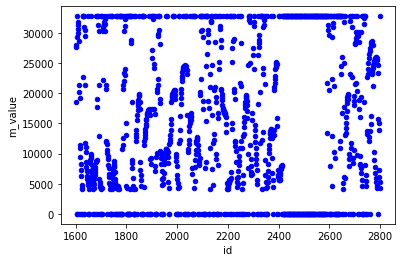

In [89]:
player_actions[1600:2800].plot(kind='scatter',x='id',y='m_value',color='blue')
plt.show()

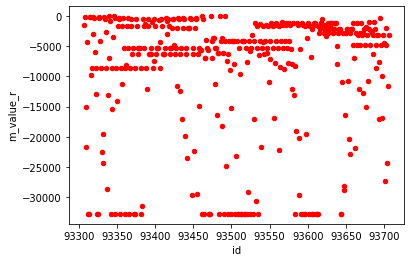

In [94]:
bot_actions[1600:2000].plot(kind='scatter',x='id',y='m_value_r',color='red')
plt.show()

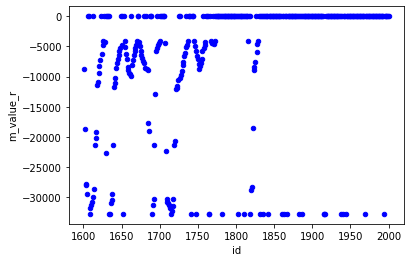

In [95]:
player_actions[1600:2000].plot(kind='scatter',x='id',y='m_value_r',color='blue')
plt.show()

Alright, enough with the graphs, lets build a data structure for a model training. We will focus on `m_ticks`, `m_value` as bots value distribution differ than human action value.

# Build few models - full data, m_ticks, and m_value

## ticks data - (ticks,action,value,value_l,value_r) - prepare the data 

In [230]:
ticks_actions = pd.DataFrame(action_list)
ticks_actions.rename(columns={0:'sessionid',
                        1:'id',
                        2:'m_ticks',
                        3:'m_kart_id',
                        4:'m_action',
                        5:'m_value',
                        6:'m_value_l',
                        7:'m_value_r',
                        8:'class'
                     }, 
                 inplace=True)
print(ticks_actions.columns)
print(ticks_actions.count())

Index(['sessionid', 'id', 'm_ticks', 'm_kart_id', 'm_action', 'm_value',
       'm_value_l', 'm_value_r', 'class'],
      dtype='object')
sessionid    76203
id           76203
m_ticks      76203
m_kart_id    76203
m_action     76203
m_value      76203
m_value_l    76203
m_value_r    76203
class        76203
dtype: int64


In [231]:
ticks_actions=ticks_actions.drop('id',axis=1)
ticks_actions=ticks_actions.drop('m_action',axis=1)
ticks_actions=ticks_actions.drop('m_value',axis=1)
ticks_actions=ticks_actions.drop('m_value_l',axis=1)
ticks_actions=ticks_actions.drop('m_value_r',axis=1)

In [232]:
ticks_actions.head()
print(ticks_actions.groupby('class',axis=0).size())

class
0    65618
1    10585
dtype: int64


Populate a dictionary with series of `m_ticks` with the same `session_id`, `m_kart_id` and `class`. the output number should indicate the same size of the data in Aurora.

In [233]:
player_session_dict = {}
i=0

for index, row in ticks_actions.iterrows():
  i=i+1
  play_action_val=row['m_ticks']
  play_action_key=row['sessionid'],row['m_kart_id'],row['class']
  if(player_session_dict.get(play_action_key)):
    session_list=player_session_dict[play_action_key]
    session_list.append(play_action_val)
    player_session_dict[play_action_key]=session_list 
  else:
    session_list=[]
    session_list.append(play_action_val)
    player_session_dict[play_action_key]=session_list
print(i)

76203


In [ ]:
import numpy as np
session_len=10
#a line in the array includes m_ticks plus the classification 
size_of_arr_line=session_len*1+1
sessions_array = np.zeros((5899,size_of_arr_line), dtype=float, order='C')
k=0
j=0
i=0
sum_of_actions=0
for key in player_session_dict:
  raw_session=player_session_dict[key]
  #break the session into equal parts session_len actions long
  sessions_list=[raw_session[i:i + session_len] for i in range(0, len(raw_session), session_len)] 
  #every session has session_len action set
  for session in sessions_list:
    #including only the full sessions with excatly 25 actions
    if(len(session)==session_len):
      k=k+1
      if(key[2]==0):
        j=j+1
      else:
        i=i+1
      new_row=[]
      for action in session:
        new_row.append(action)
      #add class field to the last column 
      new_row.append(key[2])
      sessions_array[k]=np.asarray(new_row)
       
print('number of 0 keys in full session {}'.format(j))
print('number of 1 keys in full session {}'.format(i))
print('the size of the sessions_array is {}'.format(k))

In [238]:
df=pd.DataFrame(sessions_array) 
df

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21768.0,21794.0,21830.0,21891.0,21936.0,21980.0,22101.0,22141.0,22295.0,22313.0,0.0
2,22357.0,22406.0,22449.0,22482.0,22574.0,22583.0,22662.0,22716.0,22781.0,22795.0,0.0
3,23053.0,23074.0,23446.0,23465.0,23650.0,23666.0,23723.0,23862.0,23864.0,23885.0,0.0
4,23896.0,23914.0,23922.0,23956.0,23999.0,24037.0,24105.0,24130.0,24156.0,24195.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5894,47181.0,47183.0,47185.0,47353.0,47436.0,47443.0,47455.0,47482.0,47523.0,47540.0,0.0
5895,45049.0,45096.0,45172.0,45209.0,45243.0,45258.0,45276.0,45325.0,45471.0,45649.0,0.0
5896,45683.0,45741.0,45752.0,45760.0,45782.0,45802.0,45813.0,45823.0,45903.0,45912.0,0.0
5897,45944.0,46077.0,46146.0,46287.0,46332.0,46340.0,46369.0,46446.0,46465.0,46490.0,0.0


In [239]:
print(df.groupby(session_len,axis=0).size())
df.head(1)

10
0.0    5161
1.0     738
dtype: int64


,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [243]:
feature_columns = df.columns[:-1]
label_column = df.columns[-1]

print('feature_columns={}'.format(feature_columns))
print('label_column={}'.format(label_column))

features = df[feature_columns].values.astype('float32')
labels = (df[label_column].values).astype('float32')
print(features[3])
labels[3]

feature_columns=RangeIndex(start=0, stop=10, step=1)
label_column=10
[23053. 23074. 23446. 23465. 23650. 23666. 23723. 23862. 23864. 23885.]


0.0

In [244]:
import io
import sagemaker.amazon.common as smac

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, features, labels)
buf.seek(0);

In [245]:
import boto3
import os
import sagemaker

session = sagemaker.Session()
bucket = 'stk-events'

prefix = 'bot-detect-ticks-model'
key = 'recordio-pb-data'

boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('Uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://stk-events/bot-detect-ticks-model/train/recordio-pb-data
Training artifacts will be uploaded to: s3://stk-events/bot-detect-ticks-model/output


In [246]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'linear-learner')

from sagemaker import get_execution_role

linear = sagemaker.estimator.Estimator(container,
                                       get_execution_role(), 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=session)
linear.set_hyperparameters(feature_dim=features.shape[1],
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

linear.fit({'train': s3_train_data},wait=False)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [ ]:
#delete old endpoint
#sagemaker.Session().delete_endpoint("arn:aws:sagemaker:us-west-2:163538056407:endpoint/stk-bot-detect-ticks")

In [247]:
from sagemaker.predictor import csv_serializer, json_deserializer


linear_predictor = linear.deploy(initial_instance_count=1,
                                 endpoint_name='stk-bot-detect-ticks',
                                 instance_type='ml.c4.large')
# Specify input and output formats.
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer
print('Endpoint name: {}'.format(linear_predictor.endpoint))

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!Endpoint name: stk-bot-detect-ticks


In [249]:
%%time
import pandas as pd

try:
  conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
  cur = conn.cursor()
  cur.execute("""
        select group_concat(concat(m_ticks)) as sample
                from (
                        select concat(id,"-",m_kart_id) id, m_ticks
                        from (
                                select id,m_kart_id,m_ticks
                                from (
                                        select id,m_kart_id,m_ticks
                                        from actions order by id desc limit 70) t1 order by m_kart_id limit 10) t2) t3; 
              """)
  sample_list=cur.fetchall()  
except Exception as e:
  print("Database connection failed due to {}".format(e))
sample=''.join(sample_list[0])
sample

CPU times: user 18.6 ms, sys: 0 ns, total: 18.6 ms
Wall time: 71.3 ms


'47443,46179,47181,47653,46727,47632,47436,47969,46709,46344'

In [250]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.accept = 'application/json'
linear_predictor.deserializer = json_deserializer
results = linear_predictor.predict(sample)
print(results)

{'predictions': [{'score': 0.2753039598464966, 'predicted_label': 1}]}


## Full data - (ticks,action,value,value_l,value_r) - prepare the data 

In [180]:
actions = pd.DataFrame(action_list)
actions.rename(columns={0:'sessionid',
                        1:'id',
                        2:'m_ticks',
                        3:'m_kart_id',
                        4:'m_action',
                        5:'m_value',
                        6:'m_value_l',
                        7:'m_value_r',
                        8:'class'
                     }, 
                 inplace=True)
print(actions.columns)
print(actions.count())

Index(['sessionid', 'id', 'm_ticks', 'm_kart_id', 'm_action', 'm_value',
       'm_value_l', 'm_value_r', 'class'],
      dtype='object')
sessionid    76203
id           76203
m_ticks      76203
m_kart_id    76203
m_action     76203
m_value      76203
m_value_l    76203
m_value_r    76203
class        76203
dtype: int64


We used `id` for sorting the session actions but now we dont need it anymore.

In [181]:
full_actions=actions.drop('id',axis=1)

Checking the amount of data we lose in aggreagtion. The session length is 25 so we are going loose all the session that are smaller than 25

In [185]:
print(full_actions.groupby(['sessionid'],axis=0).size())
sum=0
for i in full_actions.groupby(['sessionid'],axis=0).size():
  #print(i,end='####')
  if(i>session_len):
    sum=sum+i
print(sum)
full_actions.count()

sessionid
0        99
1       100
2       100
3       100
4       100
       ... 
1083    100
1084    100
1085    100
1086    100
1087     87
Length: 769, dtype: int64
76193


sessionid    76203
m_ticks      76203
m_kart_id    76203
m_action     76203
m_value      76203
m_value_l    76203
m_value_r    76203
class        76203
dtype: int64

Checking the size of sessions. Session is an ordered set of actions grouped by the sessiondid, the player kart id and the classification. 

Classification is set as 1 in case of human, and 0 as bot.

The `sum` is the number of remaining data after aggregating on both the kartid and class.

Construct a dictonary based on `sessionid` and action classification `class`

In [186]:
player_session_dict = {}
i=0

for index, row in full_actions.iterrows():
  i=i+1
  play_action_val=row['m_ticks'],row['m_action'],row['m_value'],row['m_value_l'],row['m_value_r']
  play_action_key=row['sessionid'],row['m_kart_id'],row['class']
  if(player_session_dict.get(play_action_key)):
    session_list=player_session_dict[play_action_key]
    session_list.append(play_action_val)
    player_session_dict[play_action_key]=session_list 
  else:
    session_list=[]
    session_list.append(play_action_val)
    player_session_dict[play_action_key]=session_list
print(i)

76203


Check the session length (number of actions in a session)

In [187]:
sum=0
for key in player_session_dict.keys():
  if (len(player_session_dict[key])>=session_len):
    #print(len(player_session_dict[key]),end = '###')
    sum=sum+len(player_session_dict[key])
print()
print('number of actions pulled from aurora={}'.format(i))
print('number of actions after initial aggregations={}'.format(sum))
len(player_session_dict)


number of actions pulled from aurora=76203
number of actions after initial aggregations=67939


3814

Transpose the dataframe to a new column strucutre that concatenates series of consecutive actions in a fixed size of 25

In [189]:
import numpy as np

#a line in the array is five set of actions plus the classification 
size_of_arr_line=session_len*5+1
sessions_array = np.zeros((5898,size_of_arr_line), dtype=float, order='C')

i=0
sum_of_actions=0
for key in player_session_dict:
  raw_session=player_session_dict[key]
  #break the session into equal parts 25 actions long
  sessions_list=[raw_session[i:i + session_len] for i in range(0, len(raw_session), session_len)]  
  #every session has 25 action set
  for session in sessions_list:
    #including only the full sessions with excatly 25 actions
    if(len(session)==session_len):
      new_row=[]
      for action in session:
        new_row.append(action[0])
        new_row.append(action[1])
        new_row.append(action[2])
        new_row.append(action[3])
        new_row.append(action[4])
      #add class field to the last column 
      new_row.append(key[2])
      sessions_array[i]=np.asarray(new_row)
      i=i+1 
print(i)

5898


In [190]:
df=pd.DataFrame(sessions_array) 

In [191]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,21768.0,0.0,32768.0,0.0,0.0,21794.0,0.0,0.0,32768.0,0.0,...,0.0,32768.0,0.0,0.0,22313.0,0.0,0.0,32768.0,0.0,0.0
1,22357.0,0.0,32768.0,0.0,0.0,22406.0,0.0,0.0,32768.0,0.0,...,7.0,32768.0,0.0,0.0,22795.0,7.0,0.0,0.0,0.0,0.0
2,23053.0,0.0,32768.0,0.0,0.0,23074.0,0.0,0.0,32768.0,0.0,...,4.0,0.0,0.0,-32768.0,23885.0,1.0,0.0,0.0,-32768.0,0.0
3,23896.0,4.0,32768.0,0.0,0.0,23914.0,4.0,0.0,0.0,0.0,...,0.0,32768.0,0.0,0.0,24195.0,0.0,0.0,32768.0,0.0,0.0
4,21777.0,1.0,32768.0,0.0,0.0,21801.0,1.0,0.0,0.0,-32768.0,...,1.0,32768.0,0.0,0.0,22163.0,1.0,0.0,0.0,-32768.0,0.0


In [192]:
print(df.groupby(session_len,axis=0).size())
df.head(1)

10
0.0        17
2.0         1
5.0         1
15.0        1
64.0        1
           ..
75795.0     1
95893.0     1
96643.0     1
96906.0     1
97667.0     1
Length: 5140, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,21768.0,0.0,32768.0,0.0,0.0,21794.0,0.0,0.0,32768.0,0.0,...,0.0,32768.0,0.0,0.0,22313.0,0.0,0.0,32768.0,0.0,0.0


To check if we did not loose data we need to multiple the number by 25

In [194]:
full_actions.groupby(['class'],axis=0).size()

class
0    65618
1    10585
dtype: int64

Check how much data was lost during transformation.

In [700]:
print(120/3817)
print(1186/36632)

0.03143830233167409
0.03237606464293514


In [195]:
print(df.columns)
feature_columns = df.columns[:-1]
label_column = df.columns[-1]

print('feature_columns={}'.format(feature_columns))
print('label_column={}'.format(label_column))

features = df[feature_columns].values.astype('float32')
labels = (df[label_column].values).astype('float32')

RangeIndex(start=0, stop=51, step=1)
feature_columns=RangeIndex(start=0, stop=50, step=1)
label_column=50


### Prepare Data and Upload to S3

In [196]:
import io
import sagemaker.amazon.common as smac

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, features, labels)
buf.seek(0);

Now we upload the data to S3 using boto3.

In [197]:
import boto3
import os
import sagemaker

session = sagemaker.Session()
bucket = 'stk-events'

prefix = 'anticheat-model'
key = 'recordio-pb-data'

boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('Uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://stk-events/anticheat-model/train/recordio-pb-data
Training artifacts will be uploaded to: s3://stk-events/anticheat-model/output


In [198]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'linear-learner')

from sagemaker import get_execution_role

linear = sagemaker.estimator.Estimator(container,
                                       get_execution_role(), 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=session)
linear.set_hyperparameters(feature_dim=features.shape[1],
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

linear.fit({'train': s3_train_data},wait=False)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


### Host Linear Classifier

Now we deploy the estimator to and endpoint.


In [ ]:
#sagemaker.Session().delete_endpoint(linear.endpoint)
from sagemaker.predictor import csv_serializer, json_deserializer

#delete old endpoint
sagemaker.Session().delete_endpoint(linear.endpoint)

linear_predictor = linear.deploy(initial_instance_count=1,
                                 endpoint_name="stk-bot-detector",
                                 instance_type='ml.m4.xlarge')
# Specify input and output formats.
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer
print('Endpoint name: {}'.format(linear_predictor.endpoint))

In [664]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.accept = 'application/json'
linear_predictor.deserializer = json_deserializer

### Calling the endpoint

prepare the parameters for the model endpoint call.

This SQL will return a game session actions (25 actions) that we trained the model with

```sql
select concat(id,"-",m_kart_id) id, m_ticks,m_action,m_value,m_value_l,m_value_r 
from (
    select id,m_kart_id,m_ticks,m_action,m_value,m_value_l,m_value_r 
    from actions order by m_kart_id,id limit 25) t;
```

Here is an example result

```
mysql> select * from tmp
    -> ;
+-------+---------+----------+---------+-----------+-----------+
| id    | ticks   |   action |   value |   value_l |   value_r |
+-------+---------+----------+---------+-----------+-----------+
| 0     |      31 |        1 |    4479 |         0 |         0 |
| 1     |      32 |        2 |   32768 |         0 |     -4479 |
| 2     |      62 |        1 |    5423 |         0 |     -4479 |
| 3     |      93 |        1 |    6317 |         0 |     -5423 |
| 4     |     124 |        1 |    5064 |         0 |     -6317 |
| 5     |     155 |        1 |    5729 |         0 |     -5064 |
| 6     |     186 |        1 |    6469 |         0 |     -5729 |
| 7     |     217 |        1 |    6714 |         0 |     -6469 |
| 8     |     248 |        0 |   32768 |         0 |     -6714 |
| 9.    |     279 |        1 |    7953 |     32768 |     -6714 |
| 10    |     310 |        1 |   14415 |     32768 |     -7953 |
| 11    |     341 |        0 |    3698 |     32768 |    -14415 |
| 12    |     372 |        0 |    5492 |      3698 |    -14415 |
| 13    |     403 |        0 |   20817 |      5492 |    -14415 |
| 14    |     434 |        0 |   26290 |     20817 |    -14415 |
| 15.   |     465 |        0 |   24373 |     26290 |    -14415 |
| 16.   |     496 |        0 |   11402 |     24373 |    -14415 |
| 17.   |     527 |        0 |   10370 |     11402 |    -14415 |
| 18.   |     558 |        0 |   12071 |     10370 |    -14415 |
| 19.   |     589 |        0 |   15223 |     12071 |    -14415 |
| 20.   |     620 |        0 |   17070 |     15223 |    -14415 |
| 21.   |     651 |        0 |   19485 |     17070 |    -14415 |
| 22.   |     682 |        0 |   16294 |     19485 |    -14415 |
| 23.   |     713 |        0 |   12267 |     16294 |    -14415 |
| 24.   |     744 |        0 |   10856 |     12267 |    -14415 |
+-------+---------+----------+---------+-----------+-----------+
```

We need to concatenate the 25 results into a single line to send it to the model endpoint.

```
+---------+----------+---------+-----------+-----------+      +---------+---------+--------+----------+----------+
| ticks_0 | action_0 | value_0 | value_l_0 | value_r_0 |..... |ticks_24 |action_24|value_24|value_l_24|value_r_24|
+---------+----------+---------+-----------+-----------+      +---------+---------+--------+----------+----------+
    31         1         4479       0            0                 744      0        10856     12267     -14415
```

```sql
select group_concat(concat(m_ticks,',',m_action,',',m_value,',',m_value_l,',',m_value_r)) as col 
from (select concat(id,"-",m_kart_id) id, m_ticks,m_action,m_value,m_value_l,m_value_r  
      from (     
          select id,m_kart_id,m_ticks,m_action,m_value,m_value_l,m_value_r      
          from actions order by m_kart_id,id limit 25) 
      t) 
t1;
```

In [665]:
%%time
import pandas as pd

modulo_size=224

try:
  conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
  cur = conn.cursor()
  cur.execute("""
        select group_concat(concat(m_ticks,',',m_action,',',m_value,',',m_value_l,',',m_value_r)) as sample
                from (
                        select concat(id,"-",m_kart_id) id, m_ticks,m_action,m_value,m_value_l,m_value_r
                        from (
                                select id,m_kart_id,m_ticks,m_action,m_value,m_value_l,m_value_r
                                from (
                                        select id,m_kart_id,m_ticks,m_action,m_value,m_value_l,m_value_r
                                        from actions order by id desc limit 70) t1 order by m_kart_id limit 25) t2) t3; 
              """)
  sample_list=cur.fetchall()  
except Exception as e:
  print("Database connection failed due to {}".format(e))
sample=''.join(sample_list[0])

CPU times: user 19.4 ms, sys: 0 ns, total: 19.4 ms
Wall time: 98.7 ms


In [666]:
sample=''.join(sample_list[0])

In [667]:
sample

'80447,0,0,32768,0,78329,1,0,0,-32768,76364,1,32768,0,0,78647,1,0,0,-32768,76891,0,0,32768,0,79382,1,32768,0,0,77409,4,0,32768,0,79825,1,0,0,-32768,77971,1,32768,0,0,80669,3,0,0,0,78484,1,32768,0,0,76713,1,32768,0,0,79121,1,0,0,-32768,77126,0,32768,0,0,79600,1,32768,0,0,77585,0,32768,0,0,80430,0,32768,0,0,78299,1,32768,0,0,76239,1,0,0,-32768,78622,1,32768,0,0,76875,0,32768,0,0,79270,1,0,0,-32768,77261,0,32768,0,0,79774,1,32768,0,0,77882,1,0,0,-32768'

In [668]:
results = linear_predictor.predict(sample)
print(results)

{'predictions': [{'score': 0.0001962552487384528, 'predicted_label': 0}]}


In [671]:
%%time
import pandas as pd

modulo_size=224

try:
  conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
  cur = conn.cursor()
  cur.execute("""
        select group_concat(concat(m_ticks,',',m_action,',',m_value,',',m_value_l,',',m_value_r)) as sample
                from (
                        select concat(id,"-",m_kart_id) id, m_ticks,m_action,m_value,m_value_l,m_value_r
                        from (
                                select id,m_kart_id,m_ticks,m_action,m_value,m_value_l,m_value_r
                                from (
                                        select id,m_kart_id,m_ticks,m_action,m_value,m_value_l,m_value_r
                                        from actions where class=1 order by id limit 70) t1 order by m_kart_id limit 25) t2) t3; 
              """)
  sample_list=cur.fetchall()  
except Exception as e:
  print("Database connection failed due to {}".format(e))
sample=''.join(sample_list[0])
sample

CPU times: user 19.1 ms, sys: 0 ns, total: 19.1 ms
Wall time: 63.7 ms


'62,1,846,0,-672,589,0,32768,32768,-32768,899,0,30620,19736,-1848,279,0,765,0,-102,651,7,32768,32768,-5391,31,1,672,0,0,837,0,3445,11325,-1848,217,1,69,0,-287,1085,0,32768,18005,-3301,434,0,32768,32768,-20774,775,0,11325,11227,-9552,155,1,456,0,-282,31,2,32768,0,-672,527,1,32768,32768,-29192,1023,1,3301,16818,-1848,372,1,9534,32768,-102,713,1,9552,32768,-19031,93,1,209,0,-846,930,0,32768,30620,-1848,310,0,508,765,-102,868,0,19736,3445,-1848,248,1,102,0,-69,806,1,1848,11325,-9552,186,1,287,0,-456,682,1,19031,32768,-5391'

In [672]:
results = linear_predictor.predict(sample)
print(results)

{'predictions': [{'score': 0.15919774770736694, 'predicted_label': 0}]}


### Clean up


We will leave the prediction endpoint running at the end of this notebook so we can handle incoming event streams. However, don't forget to delete the prediction endpoint when you're done. You can do that at the Amazon SageMaker console in the Endpoints page. Or you can run linear_predictor.delete_endpoint()